In [1]:
import wfdb
import csv
import pandas as pd
import numpy as np
import os

In [2]:
import os
import csv
import pandas as pd
import wfdb  # Make sure wfdb is installed

output_dir = "data_creation"
os.makedirs(output_dir, exist_ok=True)

# Patient numbers
patient_numbers = [
    "100", "101", "102", "103", "104", "105", "106", "107", "108", "109",
    "111", "112", "113", "114", "115", "116", "117", "118", "119", "121",
    "122", "123", "124", "200", "201", "202", "203", "205", "207", "208",
    "209", "210", "212", "213", "214", "215", "217", "219", "220", "221",
    "222", "223", "228", "230", "231", "232", "233", "234"
]

# N = normal 
# S = supra-ventricular premature
# V = ventricular escape
# F = fusion of ventricular and normal
# Q = unclassified heartbeats
symbol_to_category = {
    'N': 'N', '.': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
    'a': 'S', 'A': 'S', 'J': 'S', 'S': 'S',
    'V': 'V', 'E': 'V',
    'F': 'F',
    '/': 'Q', 'f': 'Q', 'Q': 'Q'
}

for patient_number in patient_numbers:
    try:
        # ECG data
        path_to_record = f"mit-database/{patient_number}"
        patient_record = wfdb.rdrecord(path_to_record)
        leads = patient_record.sig_name
        ecg_data = patient_record.p_signal

        # ECG CSV
        ecg_filename = f"{output_dir}/{patient_number}_ECG.csv"
        with open(ecg_filename, "w", newline='') as outfile:
            out_csv = csv.writer(outfile)
            out_csv.writerow(leads)
            for row in ecg_data:
                out_csv.writerow(row)

        # Annotations data
        annotation = wfdb.rdann(path_to_record, 'atr')
        symbols = annotation.symbol
        annotations = annotation.sample

        # Filter out symbols not in symbol_to_category
        filtered_symbols_annotations = [(sym, ann) for sym, ann in zip(symbols, annotations) if sym in symbol_to_category]
        categories = [symbol_to_category[sym] for sym, ann in filtered_symbols_annotations]
        annotations_filtered = [ann for sym, ann in filtered_symbols_annotations]

        df_annotations = pd.DataFrame({'Category': categories, 'Annotation': annotations_filtered})

        # Annotations CSV
        annotations_filename = f"{output_dir}/{patient_number}_Annotations.csv"
        df_annotations.to_csv(annotations_filename, index=False)

    except Exception as e:
        print(f"Failed to process: {patient_number}: {e}")

print("Done")

Done


In [3]:
import os
import pandas as pd
import numpy as np


def process_patient_data(patient_number, data_creation_dir="data_creation"):
    ecg_file_path = os.path.join(data_creation_dir, f"{patient_number}_ECG.csv")
    annotations_file_path = os.path.join(data_creation_dir, f"{patient_number}_Annotations.csv")
    
    patient_X = []
    patient_Y = []
    
    try:
        ecg_df = pd.read_csv(ecg_file_path)
        annotations_df = pd.read_csv(annotations_file_path)
    except FileNotFoundError:
        print(f"Files for patient {patient_number} not found. Skipping...")
        return [], []
    
    first_column_name = ecg_df.columns[0]
    second_column_name = ecg_df.columns[1] if len(ecg_df.columns) > 1 else None

    sampling_rate = 360  # Hz
    total_window_size_seconds = 2  # Total window size in seconds
    total_window_size_samples = total_window_size_seconds * sampling_rate

    for _, row in annotations_df.iterrows():
        annotation_point = row['Annotation']
        category = row['Category']
        
        # Randomly determine the window split around the annotation point
        before_seconds = np.random.uniform(0, total_window_size_seconds)
        after_seconds = total_window_size_seconds - before_seconds
        before_samples = int(before_seconds * sampling_rate)
        after_samples = int(after_seconds * sampling_rate)
        
        start_point = max(0, annotation_point - before_samples)
        end_point = start_point + total_window_size_samples  # Ensure the window is of the exact expected size
        
        # Adjust the end point if it exceeds the length of the data
        if end_point > len(ecg_df):
            end_point = len(ecg_df)
            start_point = max(0, end_point - total_window_size_samples)  # Adjust start point accordingly
        
        # Process data from the first column
        window_data_first_column = ecg_df.iloc[start_point:end_point][first_column_name].to_numpy()
        
        patient_X.append(window_data_first_column)
        patient_Y.append(category)
        
        # If there's a second column, process it and add as a new entry
        if second_column_name:
            window_data_second_column = ecg_df.iloc[start_point:end_point][second_column_name].to_numpy()
            
            patient_X.append(window_data_second_column)
            patient_Y.append(category)  # Repeat category for the new entry
    
    return patient_X, patient_Y



# Initialize lists to hold the entire dataset
all_X = []
all_Y = []

data_creation_dir = "data_creation"

# Process each patient
for patient_number in patient_numbers:
    patient_X, patient_Y = process_patient_data(patient_number, data_creation_dir)
    all_X.extend(patient_X)
    all_Y.extend(patient_Y)

X = np.array(all_X)
Y = np.array(all_Y)

In [4]:
X

array([[-0.17 , -0.155, -0.175, ..., -0.4  , -0.4  , -0.405],
       [-0.05 , -0.04 , -0.04 , ..., -0.335, -0.345, -0.355],
       [-0.145, -0.145, -0.145, ..., -0.4  , -0.415, -0.425],
       ...,
       [-0.055, -0.045, -0.04 , ..., -0.055, -0.075, -0.075],
       [-0.355, -0.35 , -0.335, ..., -0.395, -0.38 ,  0.   ],
       [ 0.03 ,  0.04 ,  0.045, ...,  0.075,  0.08 ,  0.   ]])

In [5]:
Y

array(['N', 'N', 'N', ..., 'N', 'N', 'N'], dtype='<U1')

In [6]:
df_x = pd.DataFrame(X)
df_x

,0,1,2,3,4,5,6,7,8,9,...,710,711,712,713,714,715,716,717,718,719
0,-0.170,-0.155,-0.175,-0.180,-0.190,-0.180,-0.155,-0.135,-0.155,-0.190,...,-0.400,-0.400,-0.410,-0.425,-0.410,-0.405,-0.395,-0.400,-0.400,-0.405
1,-0.050,-0.040,-0.040,-0.055,-0.075,-0.080,-0.085,-0.070,-0.080,-0.080,...,-0.295,-0.300,-0.310,-0.310,-0.315,-0.310,-0.310,-0.335,-0.345,-0.355
2,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.120,-0.135,...,-0.400,-0.400,-0.395,-0.415,-0.405,-0.390,-0.400,-0.400,-0.415,-0.425
3,-0.065,-0.065,-0.065,-0.065,-0.065,-0.065,-0.065,-0.065,-0.080,-0.080,...,-0.265,-0.270,-0.280,-0.285,-0.280,-0.255,-0.270,-0.280,-0.290,-0.290
4,-0.270,-0.260,-0.280,-0.280,-0.285,-0.275,-0.275,-0.265,-0.270,-0.285,...,-0.495,-0.385,-0.270,-0.115,0.090,0.370,0.635,0.810,0.860,0.770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218983,0.035,0.040,0.045,0.045,0.045,0.030,0.025,0.015,0.025,0.030,...,0.245,0.375,0.480,0.570,0.600,0.580,0.490,0.345,0.185,0.040
218984,-0.320,-0.290,-0.285,-0.270,-0.270,-0.275,-0.265,-0.270,-0.260,-0.255,...,-0.355,-0.340,-0.350,-0.345,-0.345,-0.345,-0.345,-0.345,-0.345,-0.350
218985,-0.055,-0.045,-0.040,-0.035,-0.055,-0.065,-0.075,-0.080,-0.060,-0.065,...,-0.020,-0.025,-0.025,-0.035,-0.030,-0.045,-0.050,-0.055,-0.075,-0.075
218986,-0.355,-0.350,-0.335,-0.285,-0.210,-0.080,0.120,0.335,0.620,0.910,...,-0.350,-0.350,-0.350,-0.365,-0.390,-0.390,-0.390,-0.395,-0.380,0.000


In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_x = scaler.fit_transform(df_x)
df_x = pd.DataFrame(df_x)


In [8]:
import pywt

def madev(d, axis=None):
    'Mean absolute deviation of a signal'
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def wavelet_denoising(x, wavelet='sym4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')


df_x = wavelet_denoising(df_x, wavelet='sym4', level=2)
df_x = pd.DataFrame(df_x)


In [9]:
df_y = pd.DataFrame(Y, columns=['ColumnName'])
print(df_y)

       ColumnName
0               N
1               N
2               N
3               N
4               N
...           ...
218983          N
218984          N
218985          N
218986          N
218987          N

[218988 rows x 1 columns]


In [10]:
value_counts_y = df_y['ColumnName'].value_counts()
print(value_counts_y)

ColumnName
N    181262
Q     16086
V     14472
S      5562
F      1606
Name: count, dtype: int64


In [11]:
df_fusionné = pd.concat([df_y, df_x], axis=1)
df_fusionné

,ColumnName,0,1,2,3,4,5,6,7,8,...,710,711,712,713,714,715,716,717,718,719
0,N,0.474334,0.476015,0.477362,0.478582,0.480290,0.481924,0.483634,0.485042,0.484807,...,0.458606,0.457968,0.458879,0.460478,0.462331,0.464437,0.466397,0.468339,0.470449,0.472537
1,N,0.483922,0.497614,0.492940,0.483447,0.485243,0.489687,0.492059,0.493934,0.494181,...,0.469044,0.467946,0.468566,0.469926,0.472245,0.474753,0.476503,0.478725,0.476904,0.473629
2,N,0.474612,0.476681,0.478513,0.480267,0.482393,0.484454,0.486574,0.488441,0.488983,...,0.457721,0.457368,0.458369,0.459992,0.461882,0.464026,0.466049,0.468091,0.470288,0.472508
3,N,0.487896,0.488640,0.489246,0.489641,0.490000,0.490324,0.490449,0.490556,0.491111,...,0.470530,0.469834,0.470798,0.472532,0.474378,0.476497,0.478879,0.481287,0.483996,0.486589
4,N,0.474040,0.477318,0.467753,0.477480,0.473316,0.468829,0.472350,0.477938,0.476848,...,0.453051,0.463103,0.474215,0.487646,0.511025,0.534446,0.562943,0.582799,0.577103,0.576425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218983,N,0.498283,0.498261,0.499375,0.501709,0.501619,0.500989,0.500972,0.501075,0.501222,...,0.529859,0.540842,0.546874,0.549591,0.554281,0.556905,0.548107,0.535476,0.519250,0.502796
218984,N,0.468224,0.468569,0.468930,0.469295,0.469632,0.469963,0.470286,0.470611,0.470985,...,0.465288,0.465590,0.465873,0.466150,0.466434,0.466720,0.467008,0.467303,0.467594,0.467892
218985,N,0.495386,0.495528,0.495702,0.495918,0.496169,0.496444,0.496761,0.497094,0.497366,...,0.496596,0.496438,0.496272,0.496106,0.495970,0.495847,0.495695,0.495559,0.495424,0.495326
218986,N,0.462573,0.478230,0.470057,0.465005,0.476507,0.495982,0.512831,0.531371,0.559301,...,0.466391,0.467490,0.466130,0.464325,0.461301,0.458693,0.460695,0.462653,0.471384,0.486887


In [12]:
line = df_fusionné.loc[df_fusionné['ColumnName'] == 'F']
line

,ColumnName,0,1,2,3,4,5,6,7,8,...,710,711,712,713,714,715,716,717,718,719
35688,F,0.472806,0.473348,0.473771,0.474064,0.474346,0.474582,0.474715,0.474801,0.474935,...,0.459613,0.460843,0.462178,0.463570,0.464899,0.466224,0.467690,0.469130,0.470613,0.471992
35689,F,0.535584,0.532416,0.534819,0.528913,0.529612,0.530197,0.527781,0.523901,0.519020,...,0.498644,0.500657,0.499058,0.496749,0.494196,0.491999,0.495271,0.503107,0.502421,0.493063
36800,F,0.467806,0.466675,0.465570,0.464395,0.463061,0.461743,0.460339,0.459041,0.458475,...,0.472317,0.471550,0.470972,0.470503,0.469977,0.469486,0.469227,0.468991,0.468855,0.468653
36801,F,0.520702,0.522471,0.524247,0.526115,0.528115,0.530090,0.532115,0.534016,0.535216,...,0.512540,0.513809,0.514680,0.515386,0.516188,0.516968,0.517559,0.518170,0.518677,0.519288
38328,F,0.493840,0.495658,0.499667,0.494864,0.497356,0.500273,0.499543,0.497814,0.498523,...,0.452148,0.454172,0.453003,0.451259,0.449724,0.448599,0.452126,0.460171,0.458878,0.449098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210255,F,0.519684,0.520759,0.525831,0.520049,0.522458,0.525152,0.523599,0.520914,0.521371,...,0.521741,0.524414,0.523654,0.521121,0.520917,0.519981,0.514656,0.512100,0.493889,0.464034
210556,F,0.411247,0.416544,0.404615,0.419664,0.416243,0.412671,0.420470,0.431167,0.431819,...,0.537343,0.539017,0.545001,0.551994,0.548385,0.539844,0.547961,0.549787,0.542236,0.551868
210557,F,0.550151,0.549828,0.554448,0.547571,0.547362,0.546779,0.541056,0.533975,0.531726,...,0.498699,0.497040,0.494538,0.492465,0.490204,0.488691,0.493948,0.505183,0.504714,0.493079
212980,F,0.482553,0.484319,0.474678,0.485021,0.480688,0.476006,0.479298,0.484797,0.484357,...,0.473798,0.469017,0.477627,0.492238,0.497657,0.501135,0.524966,0.545412,0.560436,0.587425


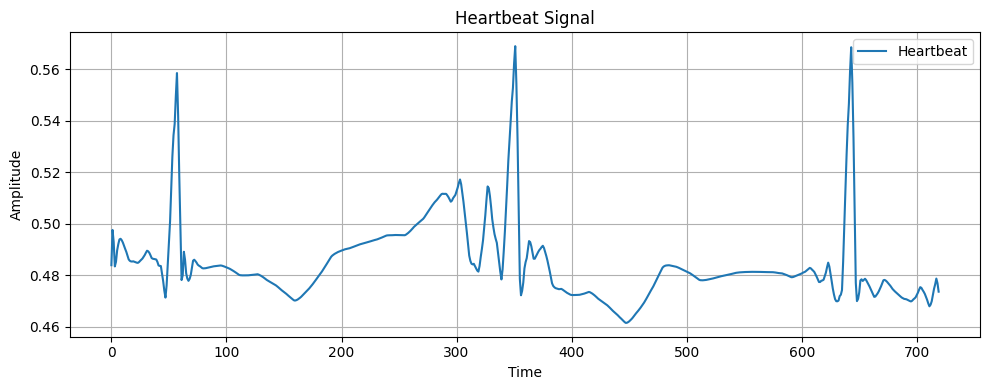

In [14]:
import matplotlib.pyplot as plt
import numpy as np

heartbeat_values = df_fusionné.iloc[1,1:]

time_axis = np.arange(0, 720)

# Plotting the heartbeat
plt.figure(figsize=(10, 4))
plt.plot(time_axis, heartbeat_values, label='Heartbeat')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Heartbeat Signal')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

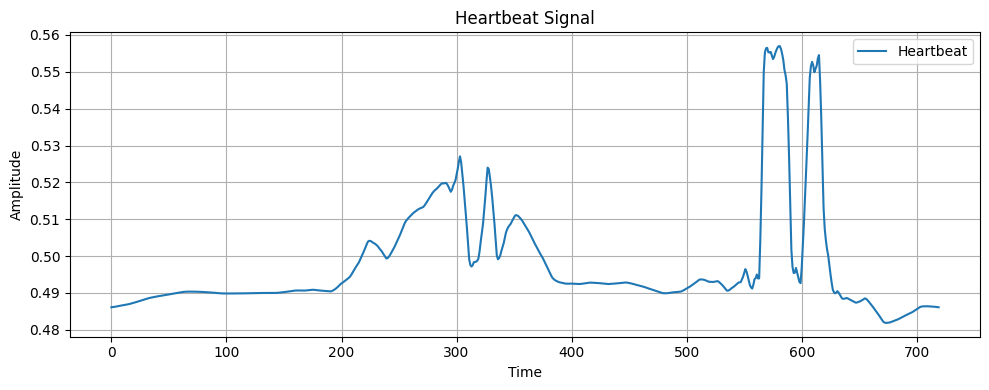

In [15]:
import matplotlib.pyplot as plt
import numpy as np

heartbeat_values = df_fusionné.iloc[5267,1:]
heartbeat_values
# Creating a time axis for the 3600 points, assuming each point represents a unit of time
time_axis = np.arange(0, 720)

# Plotting the heartbeat
plt.figure(figsize=(10, 4))
plt.plot(time_axis, heartbeat_values, label='Heartbeat')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Heartbeat Signal')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()